In [ ]:
!pip install -U nltk

     |████████████████████████████████| 1.5MB 12.4MB/s 
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import collections
import random
import numpy as np
import os
import time
import json
import pandas as pd
import re
import nltk
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
train_images_list = os.listdir('drive/MyDrive/flicker8k/Images/')

In [ ]:
len(train_images_list)

8119

In [ ]:
train_captions_results = pd.read_csv('drive/MyDrive/flicker8k/results2.csv')

In [ ]:
train_captions_results.head()

,Image_name,CommentNo,Comments
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...


In [ ]:
train_captions_results.shape

(40455, 3)

In [ ]:
def get_images_id(names):
    names = [int(x.split('_')[-1].split('.')[0]) for x in names]
    return names

In [ ]:
train_captions_results.columns = ['image_name', 'comment_number', 'comment']

In [ ]:
start_tag = '<start>'
end_tag = '<end>'

In [ ]:
def images_map_caption(train_images_list, train_captions):
    caption = []
    img_vec = []
    for i in tqdm(train_images_list):
      for j in range(5):
        try:
          caption.append(start_tag +' '+ train_captions[train_captions['image_name'] == i]['comment'].iat[j] + ' '+ end_tag)
          img_vec.append(i)
        except: pass
    return caption,img_vec

In [ ]:
train_captions,img_name_vector = np.array(images_map_caption(train_images_list, train_captions_results))
print(train_captions.shape)

100%|██████████| 8119/8119 [01:42<00:00, 78.91it/s]

(40455,)


In [ ]:
for i in range(len(img_name_vector)):
  img_name_vector[i] = 'drive/MyDrive/flicker8k/Images/' + img_name_vector[i]
  #img_name_vector[i] = 'drive/MyDrive/cvtest/' + img_name_vector[i]

In [ ]:
len(img_name_vector)

40455

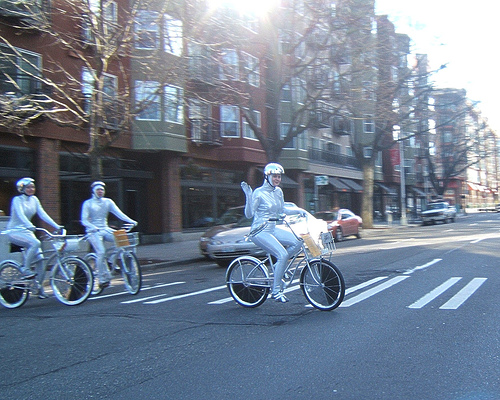

In [ ]:
Image.open(img_name_vector[0])

In [ ]:
train_captions[1]

'<start> several men in silver suits are riding bicycles across a street <end>'

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


87916544/87910968 [==============================] - 2s 0us/step


In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    #print(path_of_feature[:14] +'np/' + path_of_feature[31:])
    np.save(path_of_feature[:14] +'np/' + path_of_feature[31:], bf.numpy())


100%|██████████| 506/506 [36:55<00:00,  4.38s/it]


In [ ]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
top_k = 1500
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
                                                  lower = True)
tokenizer.fit_on_texts(train_captions)


In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
max_length = calc_max_length(train_seqs)

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 70-30 split randomly.
img_keys = list(img_to_cap_vector.keys())
train_ids, test_ids = train_test_split(img_keys, test_size = 0.3, random_state = 42, shuffle = True)
#random.shuffle(img_keys)

#slice_index = int(len(img_keys)*0.7)
#img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]
img_name_train_keys, img_name_val_keys = train_ids,test_ids

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])


In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(28315, 28315, 12140, 12140)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  name = img_name.decode('utf-8')
  img_tensor = np.load(name[:14]+'np/'+name[31:]+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 60

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.3855
Epoch 1 Batch 100 Loss 1.3471
Epoch 1 Batch 200 Loss 1.1051
Epoch 1 Batch 300 Loss 1.1366
Epoch 1 Batch 400 Loss 1.0709
Epoch 1 Loss 1.246491
Time taken for 1 epoch 125.90 sec

Epoch 2 Batch 0 Loss 1.0531
Epoch 2 Batch 100 Loss 1.0707
Epoch 2 Batch 200 Loss 1.0461
Epoch 2 Batch 300 Loss 0.9699
Epoch 2 Batch 400 Loss 0.8711
Epoch 2 Loss 0.995836
Time taken for 1 epoch 66.56 sec

Epoch 3 Batch 0 Loss 0.9900
Epoch 3 Batch 100 Loss 0.8477
Epoch 3 Batch 200 Loss 0.9265
Epoch 3 Batch 300 Loss 0.9234
Epoch 3 Batch 400 Loss 0.9156
Epoch 3 Loss 0.923038
Time taken for 1 epoch 66.21 sec

Epoch 4 Batch 0 Loss 0.8405
Epoch 4 Batch 100 Loss 0.9526
Epoch 4 Batch 200 Loss 0.8261
Epoch 4 Batch 300 Loss 0.8169
Epoch 4 Batch 400 Loss 0.8762
Epoch 4 Loss 0.872527
Time taken for 1 epoch 65.54 sec

Epoch 5 Batch 0 Loss 0.8758
Epoch 5 Batch 100 Loss 0.8567
Epoch 5 Batch 200 Loss 0.8254
Epoch 5 Batch 300 Loss 0.8605
Epoch 5 Batch 400 Loss 0.8923
Epoch 5 Loss 0.830676
Time taken fo

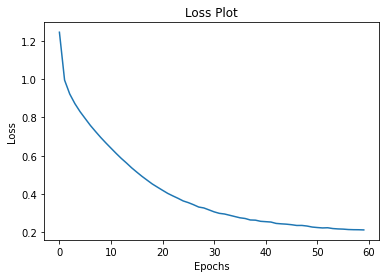

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(20,20))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


11717
Real Caption: <start> a crowd scene in a area <end>
Prediction Caption: a street scene of the city <end>


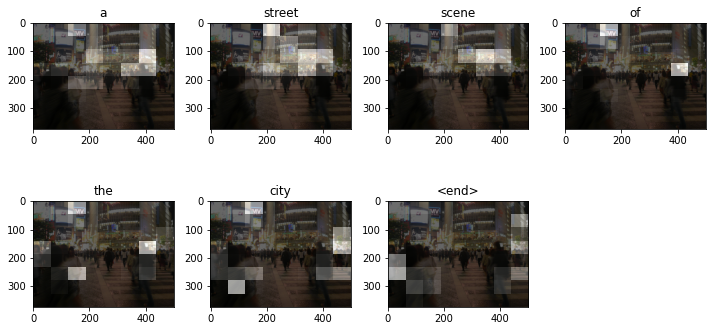

In [ ]:
rid = np.random.randint(0, len(img_name_val))
print(rid)
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

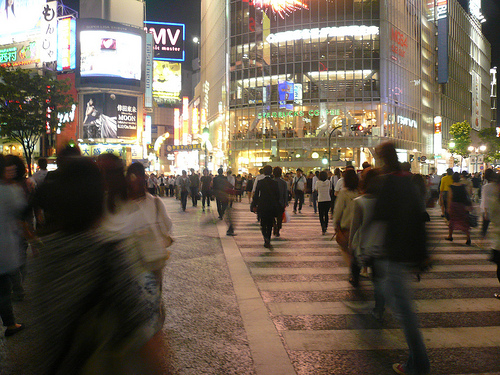

In [ ]:
Image.open(img_name_val[rid])

3984
Real Caption: <start> a young man leaps into the water <end>
Prediction Caption: a little boy in black and white is jumping in the water <end>


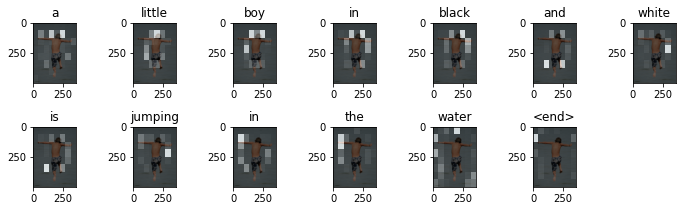

In [ ]:
rid = np.random.randint(0, len(img_name_val))
print(rid)
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

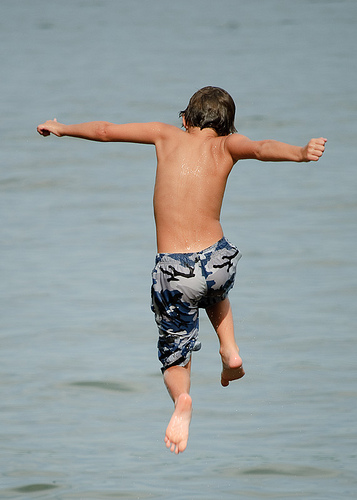

In [ ]:
Image.open(img_name_val[rid])

3474
Real Caption: <start> young boy with a black tshirt off <end>
Prediction Caption: a young man looks down with a face <end>


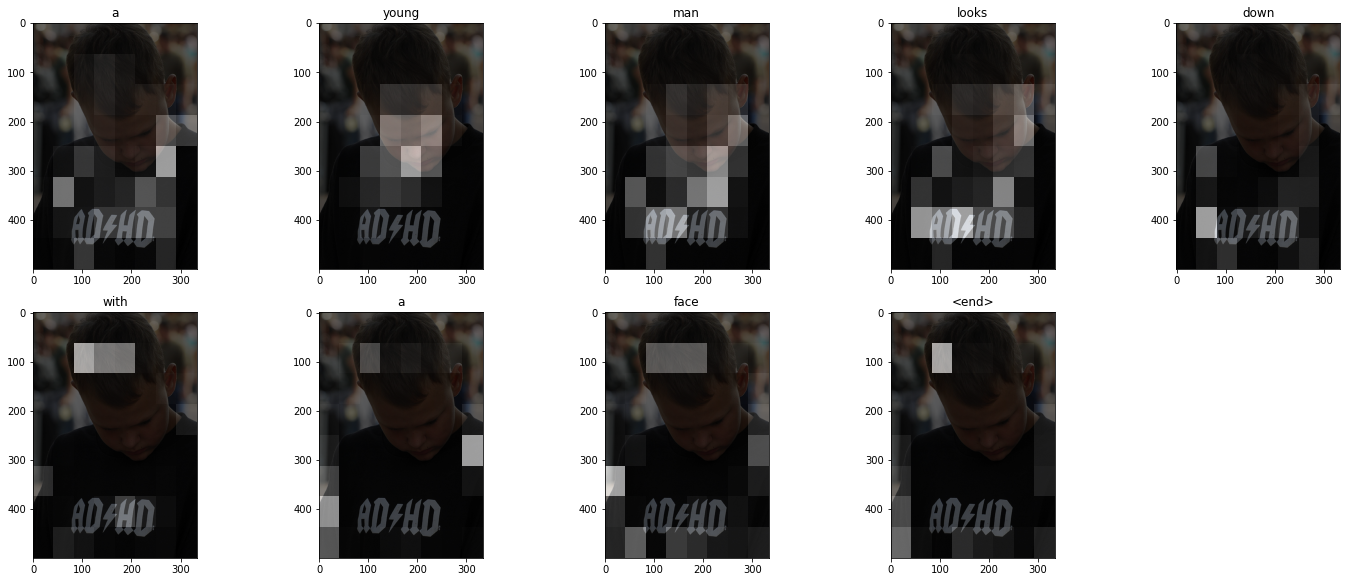

In [ ]:
rid = np.random.randint(0, len(img_name_val))
print(rid)
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

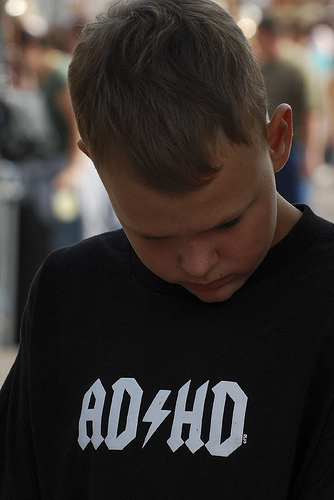

In [ ]:
Image.open(img_name_val[rid])

['a', 'group', 'of', 'mountain', 'biker', 'by', 'a', 'picture', 'of', 'motorcycle', 'and', '<end>']
['a', 'boy', 'sits', 'on', 'a', 'dirt', 'hill', '<end>']
['a', 'with', 'a', 'bicycle', 'blue', 'shirt', '<end>']


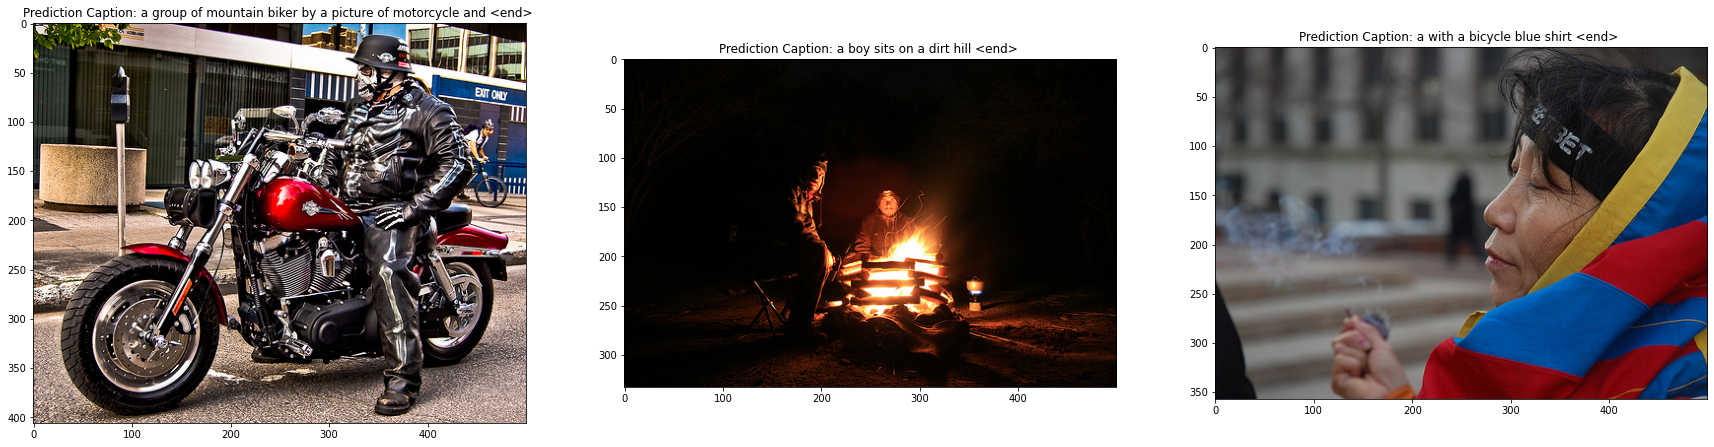

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (30,15))

seen = []
for i in range(3):
  while True:
    r = np.random.randint(0, len(img_name_val))
    if r not in seen:
      seen.append(r)
      break
  
  #photo_id = test_img_ids[r]
  #photo = img_encoding[photo_id]

  #generated_caption = greedySearch(photo)

  #img_path = os.path.join(img_dir, photo_id + '.jpg')
  #img = imread(img_path)
  #axs[i].imshow(img)
  #axs[i].set_title("generated caption : %s" %generated_caption)
  #real_caption = ' '.join([tokenizer.index_word[i]
  #                      for i in cap_val[r] if i not in [0]])
  image = img_name_val[r]
  result, attention_plot = evaluate(image)

  axs[i].imshow(Image.open(image))
  print(result)
  caption = ''
  for word in result:
    caption += word + ' '
  axs[i].set_title('Prediction Caption: %s' %caption)
plt.show()

     |████████████████████████████████| 1.5MB 8.6MB/s 
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
img_name_val[0]

'drive/MyDrive/flicker8k/Images/2934801096_230ae78d7e.jpg'

In [ ]:
def evaluate_test(subset_size = 200):
  avg_b1 = 0
  avg_b2 = 0
  #images = list(test.keys())
  avg_meteor = 0
  for id in tqdm(range(0,subset_size*5, 5)):
    test_img = img_name_val[id]
    #generated_caption = greedySearch(photo)
    real_captions= []
    for j in range(id,id+5):

      real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[j] if i not in [0]])
    
    #test_captions = test[test_img]
      real_caption = real_caption[7:]
      real_caption = real_caption[:-6]
      real_captions.append(real_caption)
    result, attention_plot = evaluate(test_img)
    meteor = meteor_score(real_captions, ' '.join(result[:-1]))
    avg_meteor += meteor
    references = [x.split(' ') for x in real_captions]
    candidate = result[:-1]
    #print(real_caption)
    #print(' '.join(candidate))
    #print(test_img)
    #Image.open(test_img)
    b1 = sentence_bleu(references, candidate, weights = (1,0))
    b2 = sentence_bleu(references, candidate, weights = (0.5,0.5))

    avg_b1 += b1
    avg_b2 += b2

  avg_b1/=subset_size
  avg_b2/=subset_size
  avg_meteor /= subset_size
  return avg_b1,avg_b2, avg_meteor  

In [ ]:
evaluate_test(200)

  0%|          | 1/200 [00:00<00:32,  6.21it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
100%|██████████| 200/200 [00:41<00:00,  4.87it/s]


(0.4374307693949945, 0.22841318590017426, 0.30784694111777894)

In [ ]:
evaluate_test(2428)



  0%|          | 0/2428 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  :type epsilon: float


  0%|          | 1/2428 [00:00<06:08,  6.58it/s]

  0%|          | 2/2428 [00:00<05:56,  6.80it/s]

  0%|          | 3/2428 [00:00<09:13,  4.38it/s]

  0%|          | 4/2428 [00:00<09:18,  4.34it/s]

  0%|          | 5/2428 [00:01<09:57,  4.06it/s]

  0%|          | 6/2428 [00:01<08:54,  4.53it/s]

  0%|          | 7/2428 [00:01<09:02,  4.46it/s]

  0%|          | 8/2428 [00:01<09:47,  4.12it/s]

  0%|          | 9/2428 [00:02<08:37,  4.68it/s]

  0%|          | 10/2428 [00:02<10:41,  3.77it/s]

  0%|          | 11/2428 [00:02<10:25,  3.86it/s]

  0%|          | 12/2428 [00:02<09:13,  4.37it/s]

  1%|          | 13/2428 [00:03<08:50,  4.55it/s]

  1%|          | 14/2428 [00:03<08:04,  4.98it/s]

  1%|          | 15/2428 [00

(0.3885246943570939, 0.2563932355890413)